In [156]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


1.14.0


In [157]:
Y = 'FE'

In [158]:
df = pd.read_csv('data/prepared.csv', sep='\t')

In [159]:
df.head(2)

,AX-94422082,AX-94598030,AX-94669331,AX-95183288,AX-94690456,AX-94966051,AX-94889872,AX-94583145,AX-94815021,AX-95142467,...,AX-95210726,FE,Balcarce,Azul,MsJz,2012,2013,2014,2015,2016
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,58.79,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,53.73,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [160]:
#df.drop(columns={'2012','2013','2014','2015','2016'}, inplace=True)

In [161]:
#df.drop(columns={'Balcarce','Azul','MsJz'}, inplace=True)

In [162]:
df.head(2)

,AX-94422082,AX-94598030,AX-94669331,AX-95183288,AX-94690456,AX-94966051,AX-94889872,AX-94583145,AX-94815021,AX-95142467,...,AX-95210726,FE,Balcarce,Azul,MsJz,2012,2013,2014,2015,2016
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,58.79,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,53.73,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [163]:
train_dataset = df.sample(frac=0.8,random_state=1)
test_dataset = df.drop(train_dataset.index)


In [164]:
train_stats = train_dataset.describe()
train_stats.pop(Y)
train_stats = train_stats.transpose()



In [165]:
train_labels = train_dataset.pop(Y)
test_labels = test_dataset.pop(Y)


In [175]:
normed_train_data = train_dataset
normed_test_data = test_dataset


In [176]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
#normed_train_data = norm(train_dataset)
#normed_test_data = norm(test_dataset)


In [177]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
      ])

    optimizer = tf.keras.optimizers.RMSprop(0.0001)

    model.compile(loss='mean_squared_error',
        optimizer=optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error','mean_absolute_percentage_error'])
    return model


In [178]:
model = build_model()


In [179]:
model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 64)                514176    
_________________________________________________________________
dense_37 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 65        
Total params: 518,401
Trainable params: 518,401
Non-trainable params: 0
_________________________________________________________________


In [180]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result


array([[-0.72435   ],
       [ 0.03923507],
       [-0.1628457 ],
       [-0.5646774 ],
       [-1.6313691 ],
       [-1.1665626 ],
       [-0.28591406],
       [-0.9595667 ],
       [-0.32446164],
       [-0.48895103]], dtype=float32)

In [181]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)        
EPOCHS = 1000
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[early_stop, PrintDot()])



......................

In [182]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,val_loss,val_mean_absolute_error,val_mean_squared_error,val_mean_absolute_percentage_error,epoch
17,503.985683,15.894456,503.985718,28.826916,423.715159,16.565720,423.715118,30.489130,17
18,504.360809,15.917162,504.360779,28.783472,422.926632,16.513832,422.926605,31.189245,18
19,502.818660,15.984942,502.818695,28.938625,424.337295,16.478745,424.337311,31.597616,19
20,500.854343,15.884352,500.854248,28.823532,423.672281,16.452141,423.672302,31.092005,20
21,500.641273,15.920479,500.641266,28.881840,426.982601,16.487366,426.982605,31.867020,21


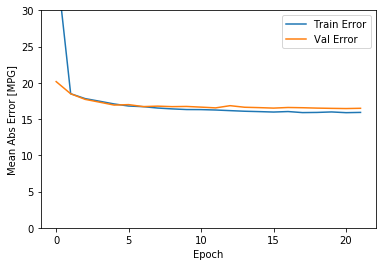

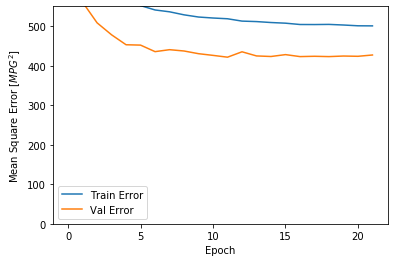

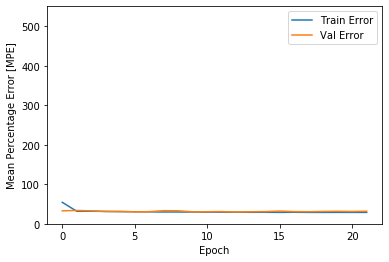

In [183]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.ylim([0,30])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.ylim([0,550])
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Percentage Error [MPE]')
    plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
    plt.ylim([0,550])
    plt.legend()
    plt.show()

    
    

plot_history(history)


In [184]:
loss, mae, mse, mape = model.evaluate(normed_test_data, test_labels, verbose=0)
loss, mae, mse, mape

(357.11166734931885, 15.350173, 357.11166, 29.271439)

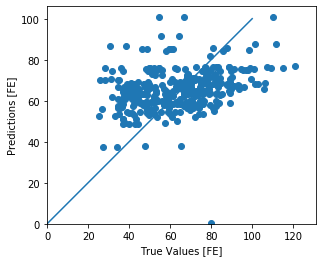

In [185]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [' + Y + ']')
plt.ylabel('Predictions [' + Y + ']')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


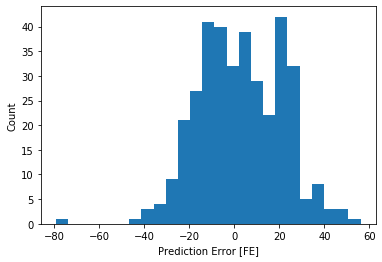

In [186]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [" + Y + "]")
_ = plt.ylabel("Count")


In [191]:
df_less = pd.read_csv('data/prepared_more.csv', sep='\t')

In [192]:
df_less.head(2)

,AX-94422082,AX-94598030,AX-94669331,AX-95183288,AX-94690456,AX-94966051,AX-94889872,AX-94583145,AX-94815021,AX-95142467,...,AX-95210726,FE,Balcarce,Azul,MsJz,2012,2013,2014,2015,2016
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,51.11,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,54.98,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [193]:
labels = df_less.pop('FE')

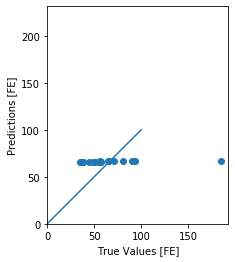

In [194]:
test_predictions = model.predict(df_less).flatten()

plt.scatter(labels, test_predictions)
plt.xlabel('True Values [' + Y + ']')
plt.ylabel('Predictions [' + Y + ']')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [50]:
test_dataset.head(2)

,Chr1A-B1-Hap1,Chr1A-B1-Hap2,Chr1A-B1-Hap3,Chr1A-B1-Hap4,Chr1A-B1-Hap5,Chr1A-B1-Hap6,Chr1A-B1-Hap7,Chr1A-B2-Hap1,Chr1A-B2-Hap2,Chr1A-B2-Hap3,...,Chr7D-B16-Hap2,Chr7D-B17-Hap1,Balcarce,Azul,MsJz,2012,2013,2014,2015,2016
15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [51]:

def f_city(x):
    if x['Balcarce'] == 1.0: return 'Balcarce'
    if x['Azul'] == 1.0: return 'Azul'
    if x['MsJz'] == 1.0: return 'MsJz'

test_dataset['city'] = test_dataset.apply(f_city, axis=1)



In [52]:


def f_year(x):
    if x['2012'] == 1.0: return '2012'
    if x['2013'] == 1.0: return '2013'
    if x['2014'] == 1.0: return '2014'
    if x['2015'] == 1.0: return '2015'
    if x['2016'] == 1.0: return '2016'

test_dataset['year'] = test_dataset.apply(f_year, axis=1)

In [53]:
test_dataset.head(2)

,Chr1A-B1-Hap1,Chr1A-B1-Hap2,Chr1A-B1-Hap3,Chr1A-B1-Hap4,Chr1A-B1-Hap5,Chr1A-B1-Hap6,Chr1A-B1-Hap7,Chr1A-B2-Hap1,Chr1A-B2-Hap2,Chr1A-B2-Hap3,...,Balcarce,Azul,MsJz,2012,2013,2014,2015,2016,city,year
15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Balcarce,2014
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,MsJz,2013


In [54]:
test_dataset.year.unique()

array(['2014', '2013', '2015', '2016', '2012'], dtype=object)

In [55]:
test_labels[:10]

15    79.76
20    34.48
21    37.96
24    43.61
25    51.90
43    38.01
44    63.31
55    36.85
63    71.95
77    31.57
Name: FE, dtype: float64

In [56]:
example_batch = normed_test_data
example_result = model.predict(example_batch)
example_result[:10]


array([[79.669785],
       [45.11412 ],
       [45.562153],
       [41.281357],
       [46.8625  ],
       [34.956764],
       [61.840958],
       [46.372375],
       [83.16701 ],
       [43.255634]], dtype=float32)

In [57]:
res = [x[0] for x in example_result]

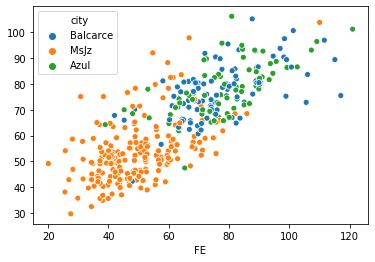

In [58]:
sns.scatterplot(x=test_labels,y=res,hue=test_dataset.city)
plt.show()

In [59]:
import eli5
from eli5.sklearn import PermutationImportance


ModuleNotFoundError: No module named 'eli5'

In [25]:
perm = PermutationImportance(model, random_state=1, scoring="r2").fit(normed_train_data,train_labels)


In [26]:
eli5.show_weights(perm, feature_names = normed_train_data.columns.tolist())


Weight,Feature
0.1437 ± 0.0127,Balcarce
0.1240 ± 0.0089,MsJz
0.0019 ± 0.0013,Azul
0.0015 ± 0.0008,Chr3B-B91-Hap2
0.0015 ± 0.0007,Chr1A-B42-Hap4
0.0015 ± 0.0012,Chr3A-B39-Hap2
0.0013 ± 0.0004,Chr4A-B20-Hap3
0.0013 ± 0.0004,Chr4A-B48-Hap5
0.0013 ± 0.0005,Chr5B-B28-Hap2
0.0012 ± 0.0006,Chr5A-B74-Hap3


In [ ]:
sns.scatterplot(x=test_labels,y=res,hue=test_dataset.year)
plt.show()

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)


In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
